In [1]:
import pandas as pd
import os
from project.dataset import Dataset, VALDODataset
from project.preprocessing import z_score_normalization, min_max_normalization, NiftiToTensorTransform
from project.training import split_train_val_datasets
from project.utils import collate_fn, plot_all_slices, plot_all_slices_from_array
from torch.utils.data import DataLoader
import torch
from project.model import VisionTransformer
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F

In [2]:
d_model = 3
n_classes = 2
img_size = (512,512)
patch_size = (16,16)
n_channels = 1
n_heads = 3
n_layers = 3
batch_size = 1
epochs = 3
alpha = 0.004

In [3]:
ds = Dataset()

In [4]:
masks = ds.load_cmb_masks(cohort_num=1)
cases = ds.load_skullstripped_mri(cohort_num=1)
# cases = ds.load_raw_mri(cohort_num=1)

In [5]:
transform = NiftiToTensorTransform(target_shape=img_size)

In [6]:
dataset = VALDODataset(
    cases=cases, 
    masks=masks, 
    transform=transform,
    normalization=z_score_normalization
)

In [7]:
sample_output = [
    
]

5


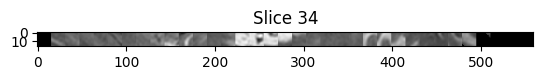

In [8]:
# cropped_locations = dataset.get_cropped_locations(img=dataset[0][0], x_min=164, y_min=327, x_max=172, y_max=336)
cropped_locations = dataset.get_cropped_locations(img=dataset[0][0], x_min=160, y_min=324, x_max=176, y_max=340)

4


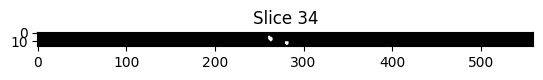

In [9]:
cropped_labels = dataset.get_cropped_locations(img=dataset[0][1], x_min=263, y_min=215, x_max=279, y_max=231)

In [20]:
print(cropped_labels.__len__())

35


In [10]:
print(type(dataset))
print(len(dataset))

<class 'project.dataset.valdo.VALDODataset'>
11


In [11]:
has_cmb = [1 if count > 0 else 0 for count in dataset.cmb_counts]

df_dataset = pd.DataFrame({
    'MRI Scans': dataset.cases,
    'Segmented Masks': dataset.masks,
    'CMB Count': dataset.cmb_counts,
    'Has CMB': has_cmb
})

In [12]:
train_dataset, val_dataset = split_train_val_datasets(
    df=df_dataset, 
    transform=transform
)

In [13]:
train_loader = DataLoader(
    train_dataset, 
    shuffle=True, 
    batch_size=batch_size,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    val_dataset, 
    shuffle=False, 
    batch_size=batch_size,
    collate_fn=collate_fn
)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
transformer = VisionTransformer(
    d_model=d_model,
    n_classes=n_classes,
    img_size=img_size,
    patch_size=patch_size,
    n_channels=n_channels,
    n_heads=n_heads,
    n_layers=n_layers,
    device=device
)

In [16]:
transformer = transformer.to(device)

In [17]:
optimizer = Adam(transformer.parameters(), lr=alpha)
criterion = nn.CrossEntropyLoss()

c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch 1/3 loss: 0.000:   0%|          | 0/8 [00:00<?, ?it/s]

5


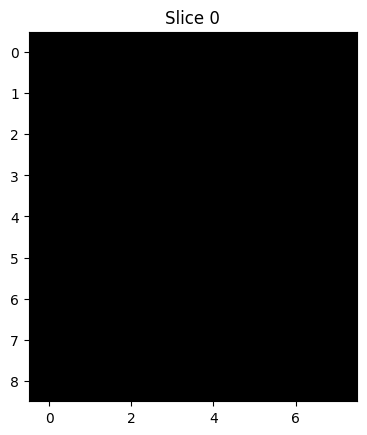

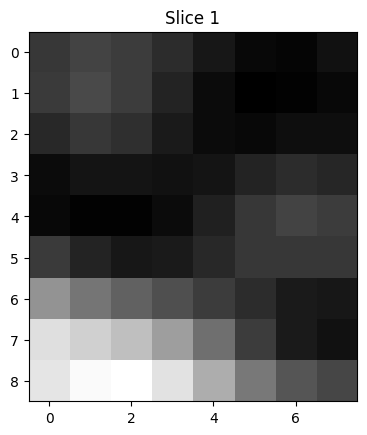

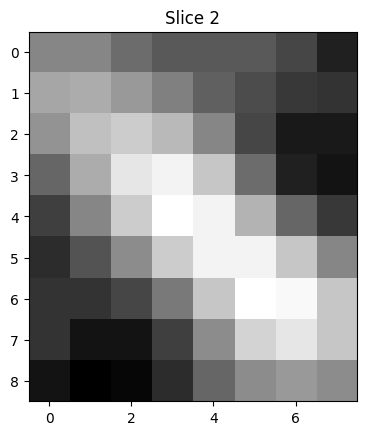

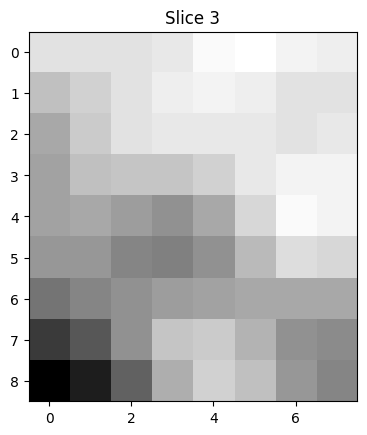

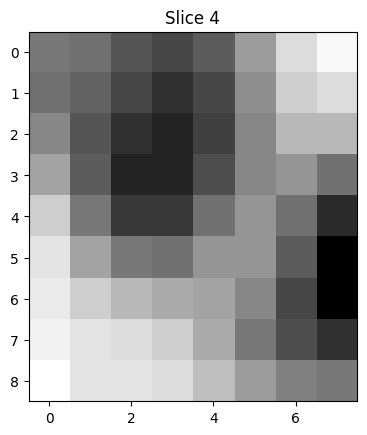

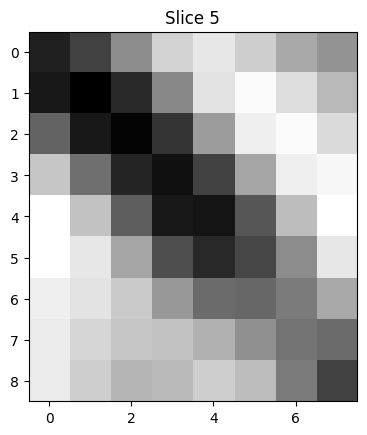

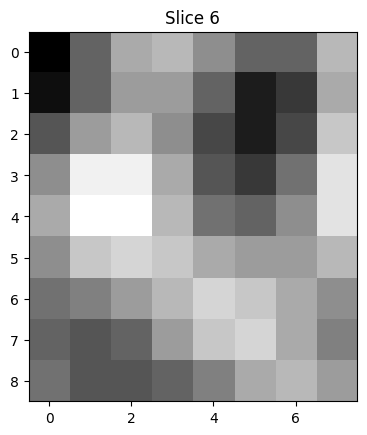

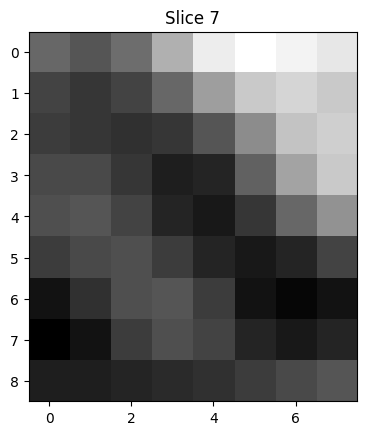

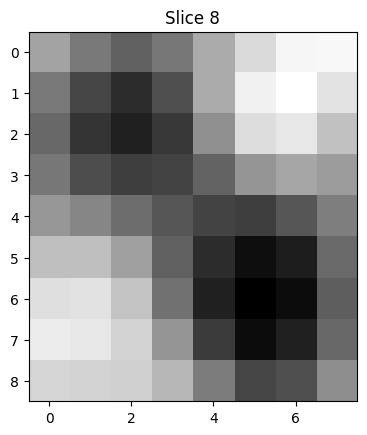

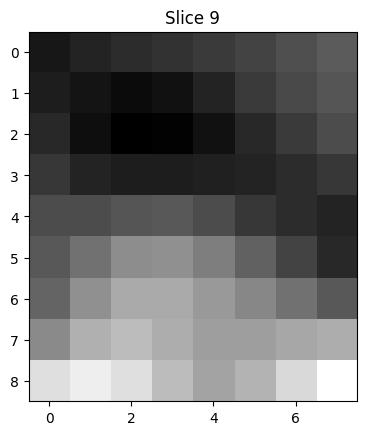

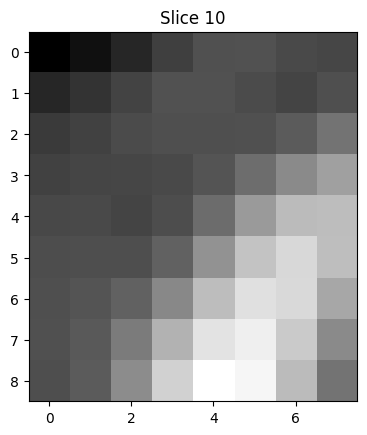

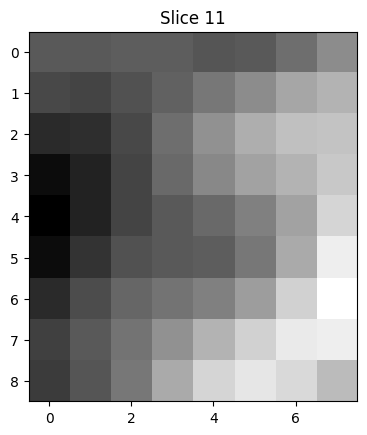

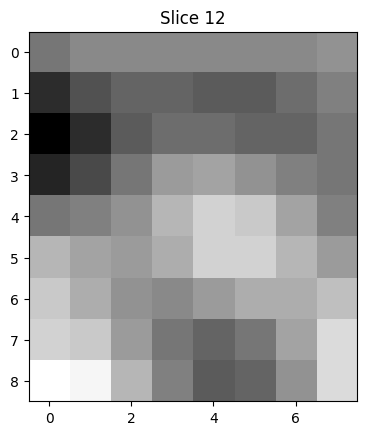

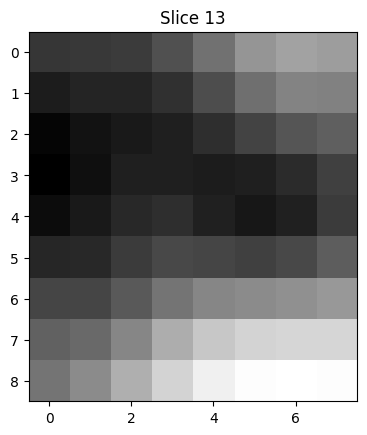

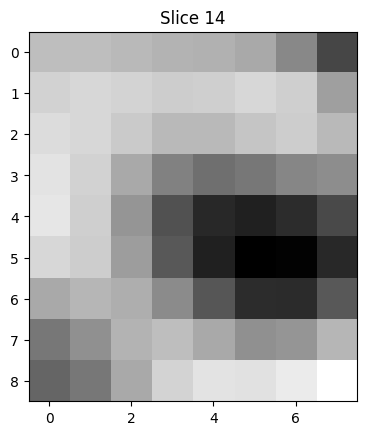

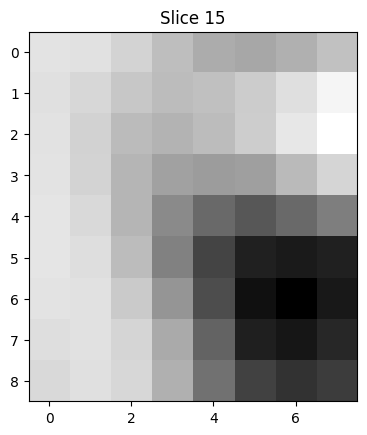

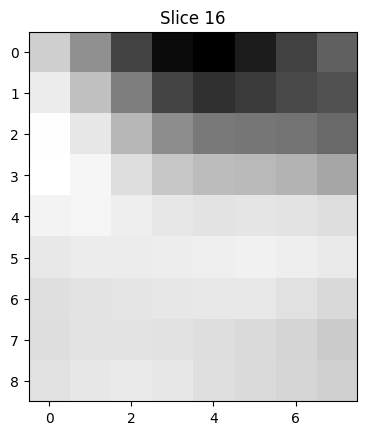

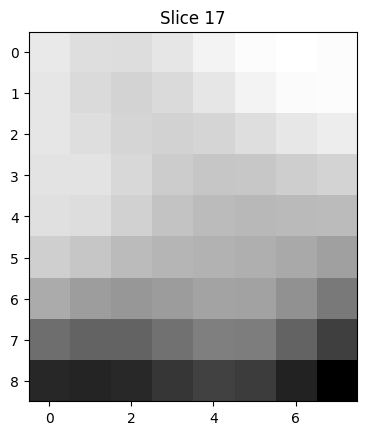

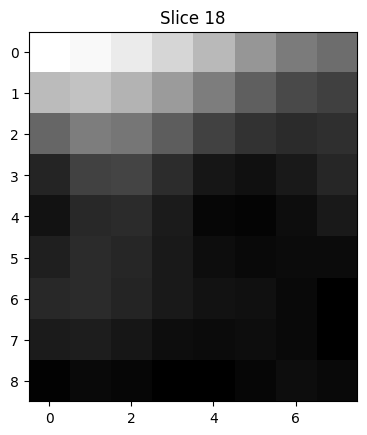

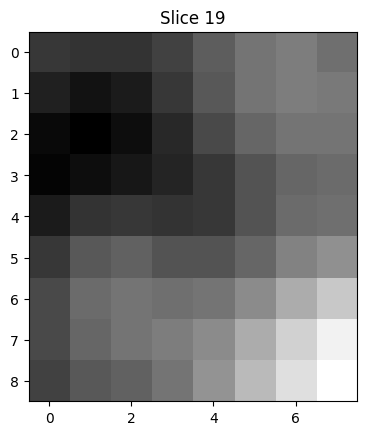

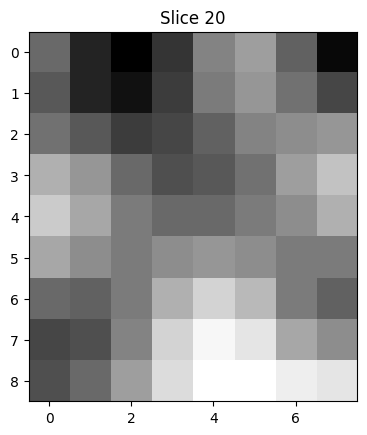

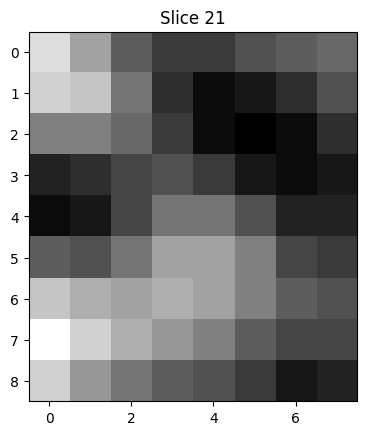

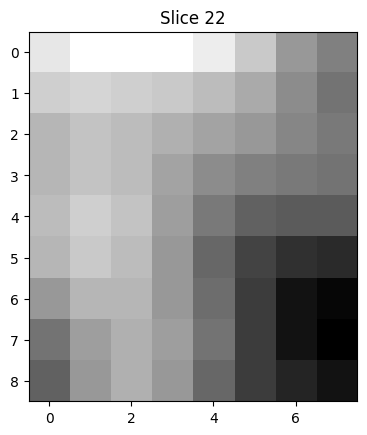

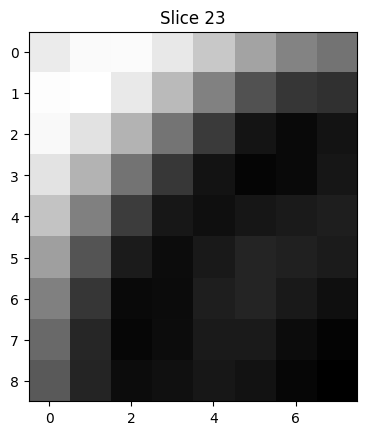

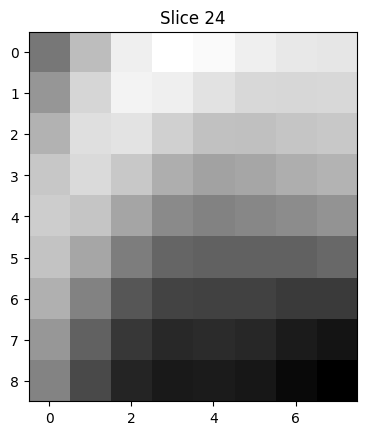

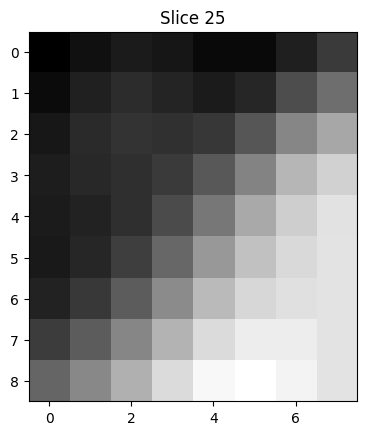

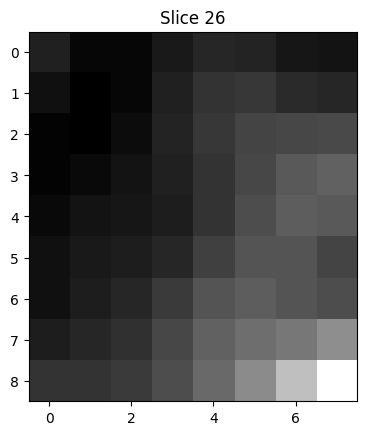

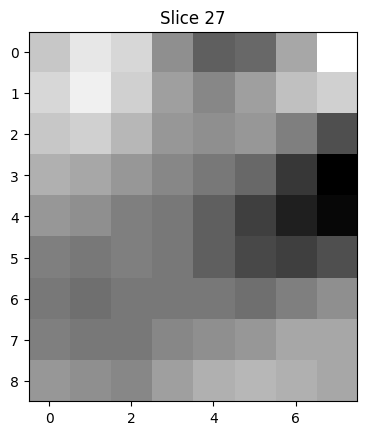

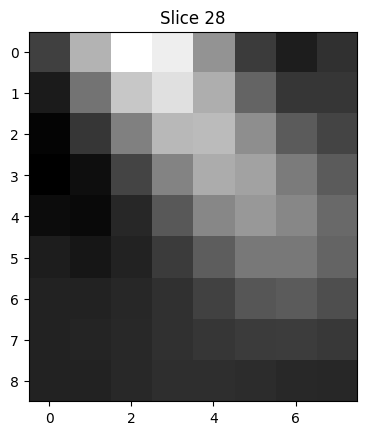

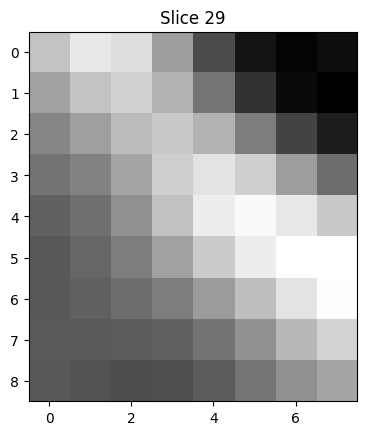

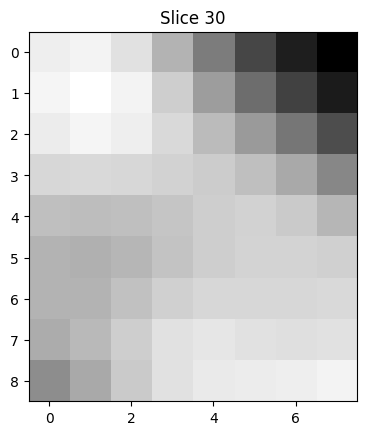

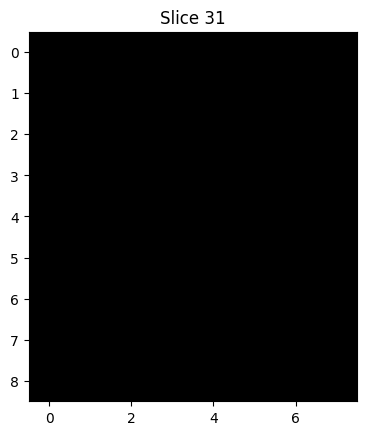

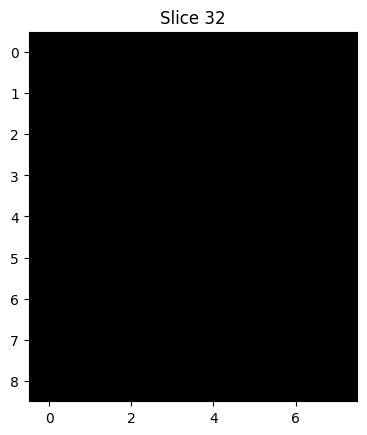

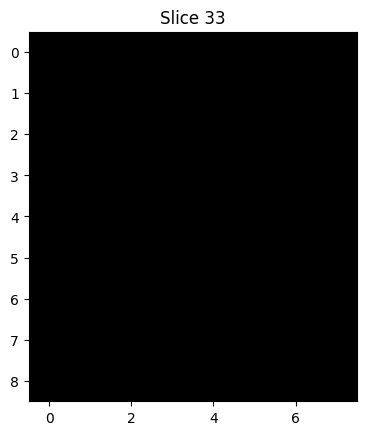

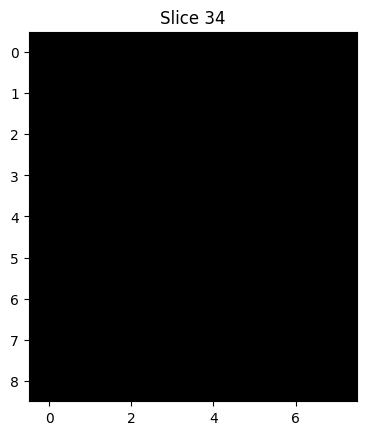

4


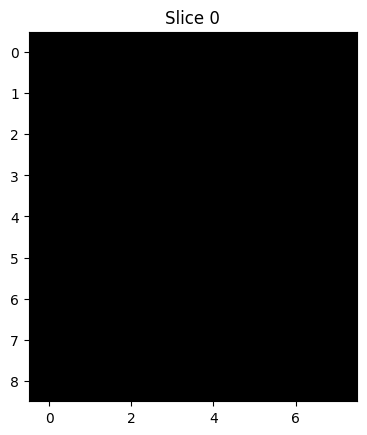

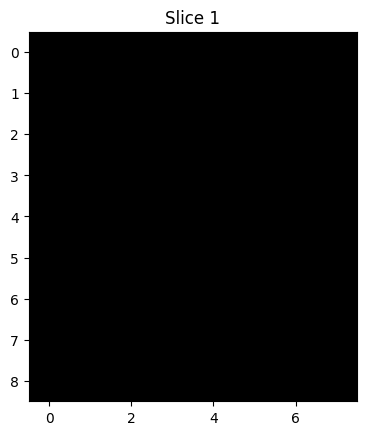

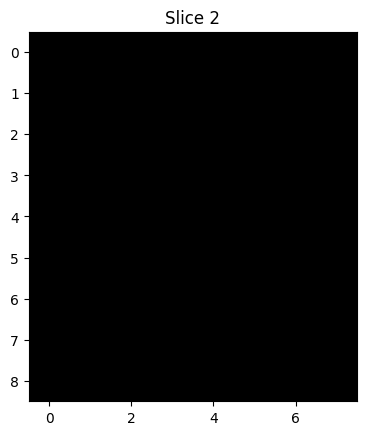

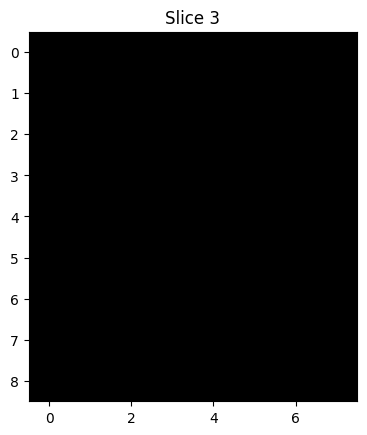

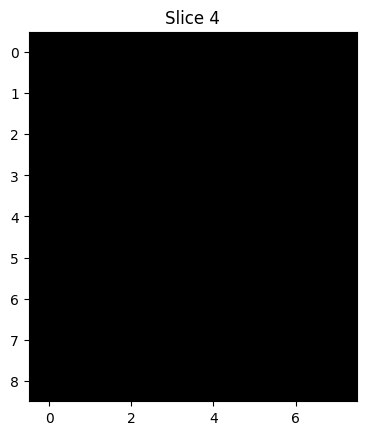

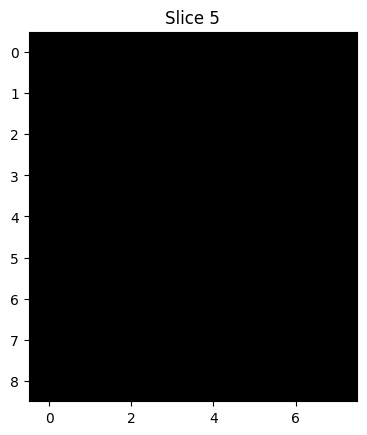

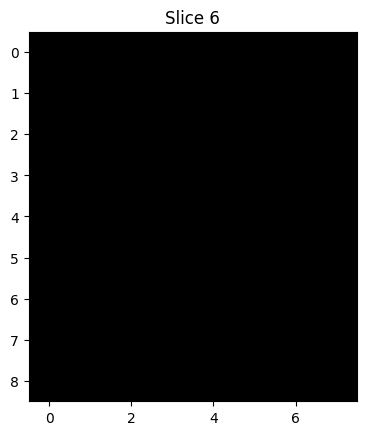

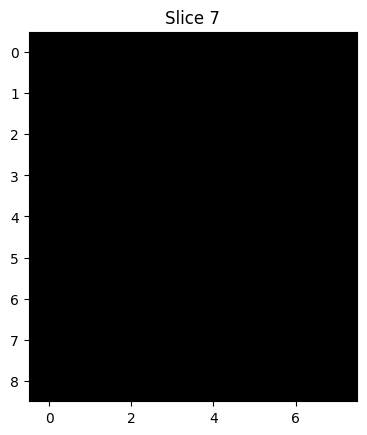

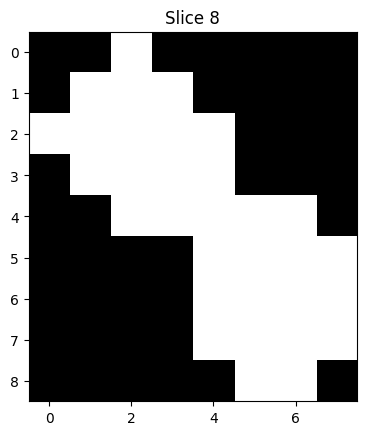

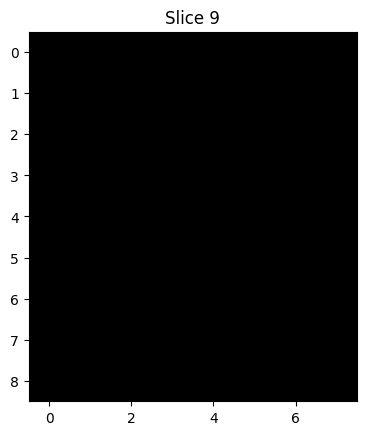

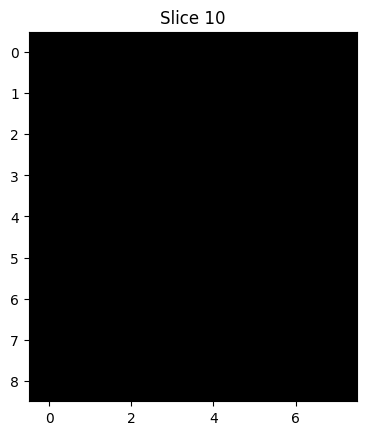

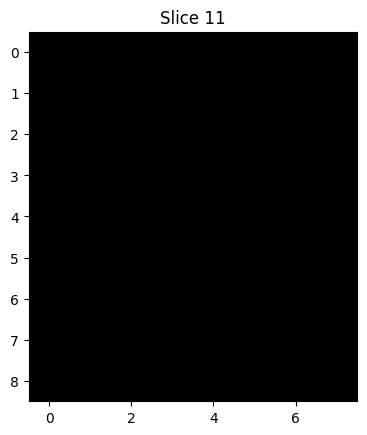

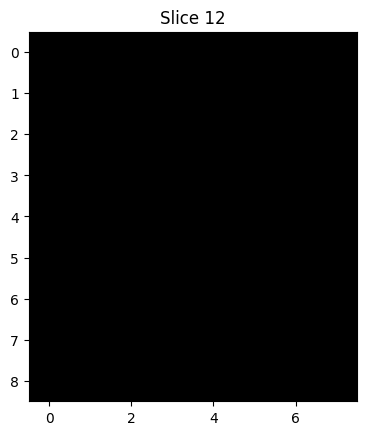

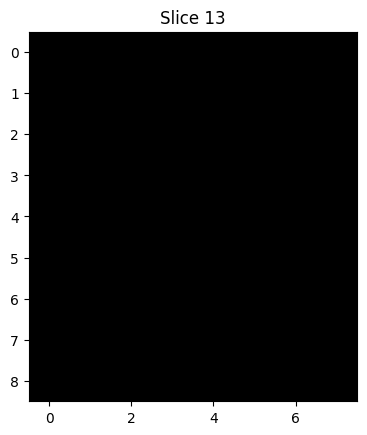

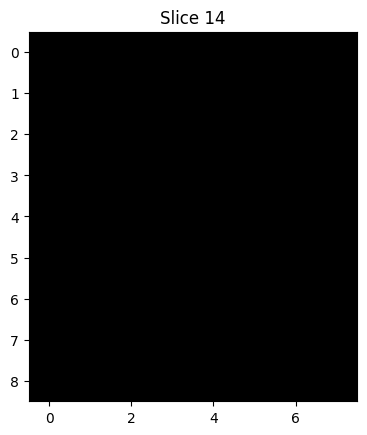

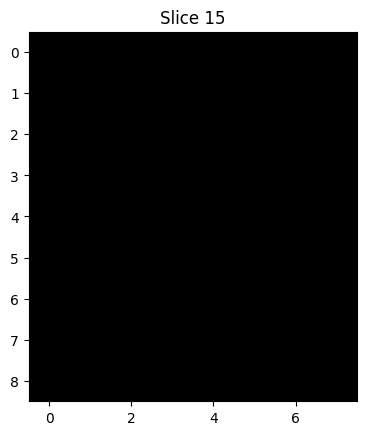

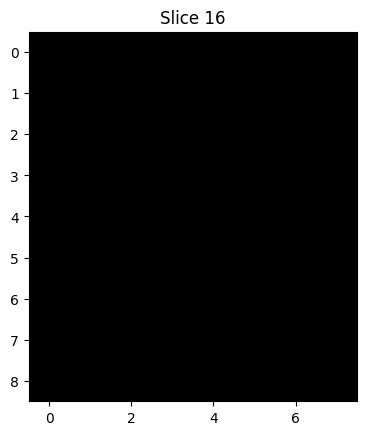

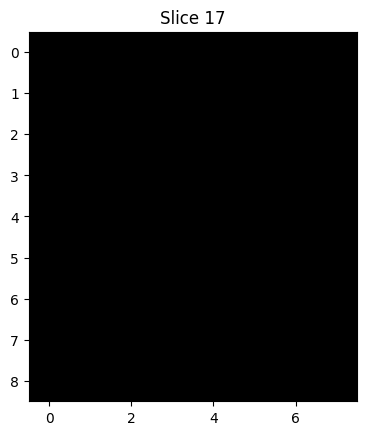

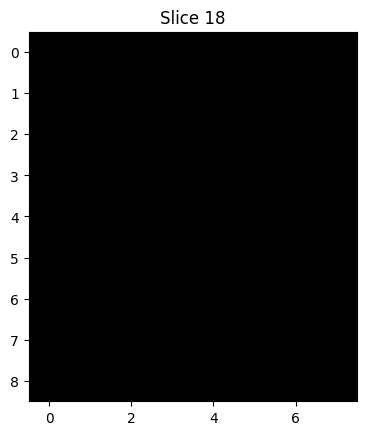

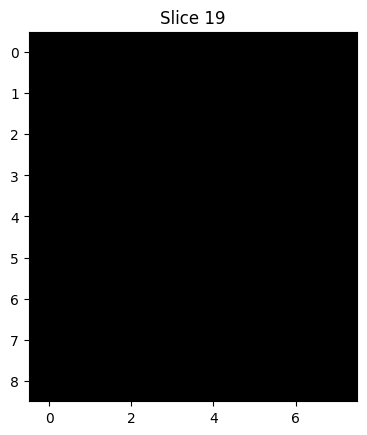

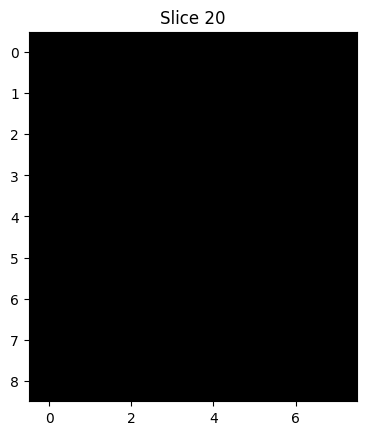

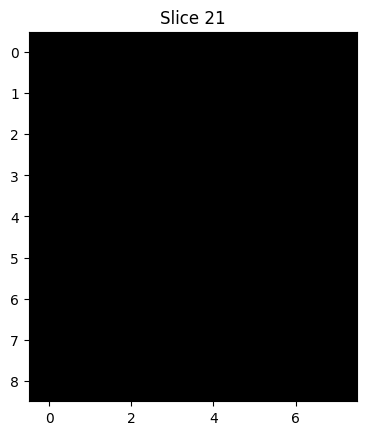

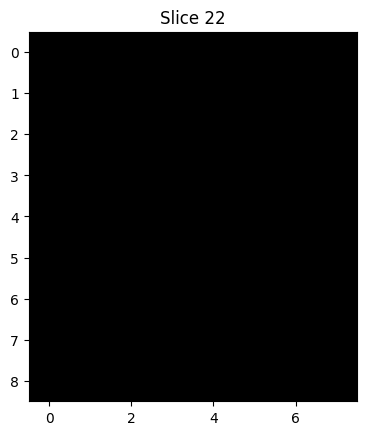

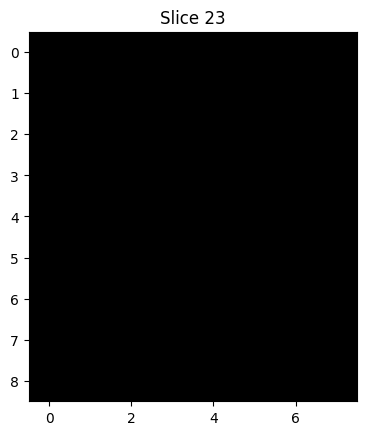

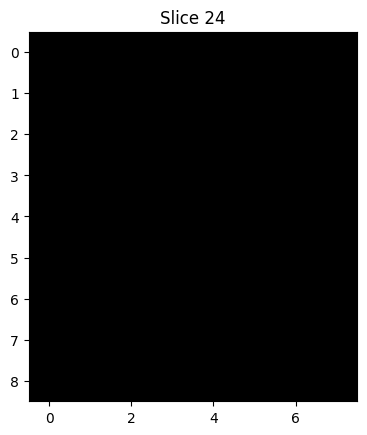

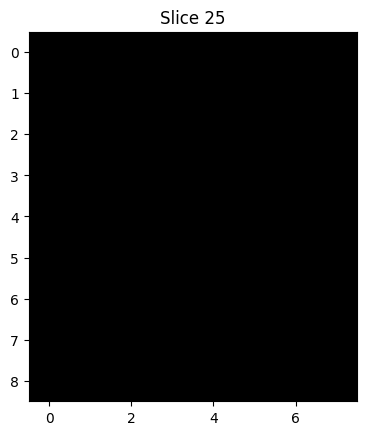

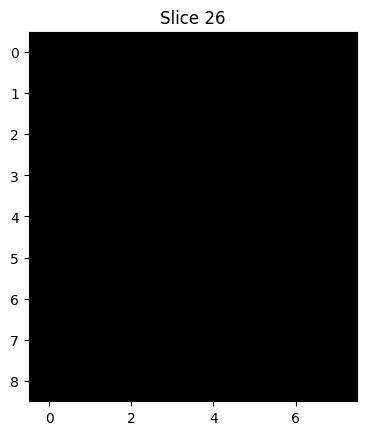

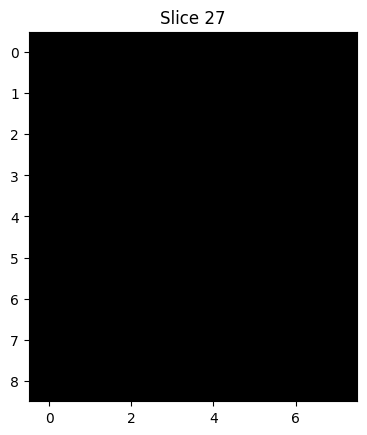

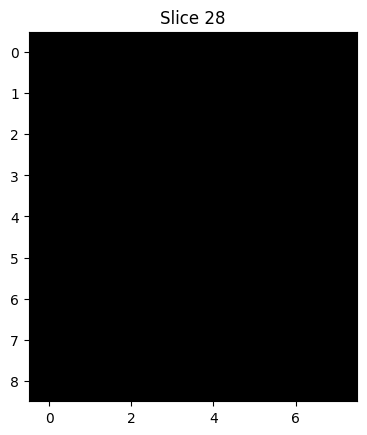

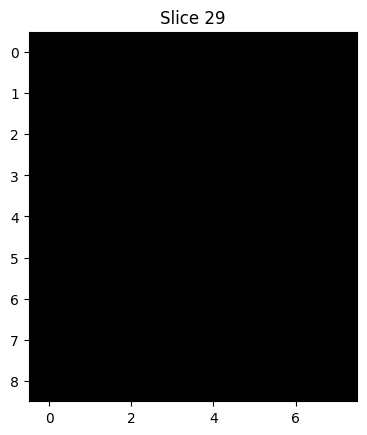

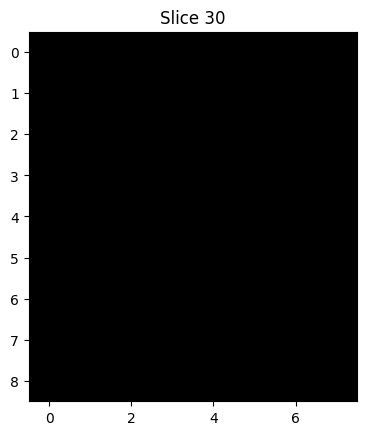

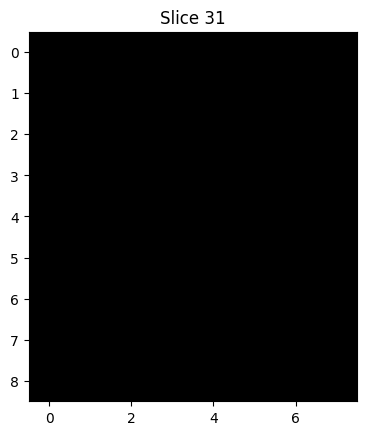

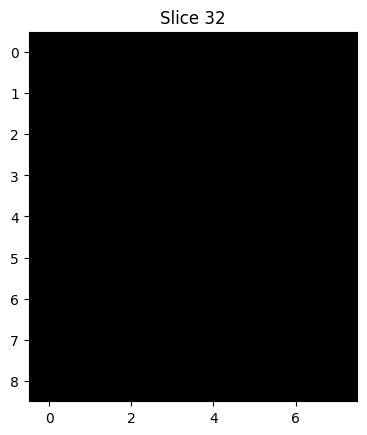

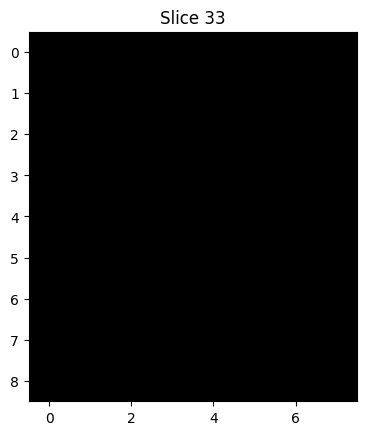

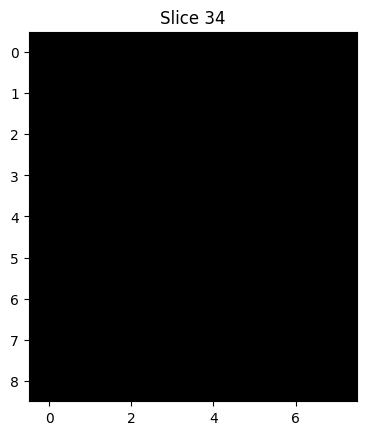

Epoch 1/3 loss: 0.000:   0%|          | 0/8 [00:09<?, ?it/s]


AttributeError: 'list' object has no attribute 'float'

In [18]:
from tqdm.auto import tqdm

for epoch in range(epochs):
    training_loss = 0.0
    progress_bar = tqdm(
        enumerate(train_loader, 0),
        total=len(train_loader),
        desc=f'Epoch {epoch + 1}/{epochs} loss: {training_loss / len(train_loader):.3f}'
    )
    
    for i, data in progress_bar:
        num_slices = len(data[0])

        cropped_images = dataset.get_cropped_locations(img=data[0], x_min=164, y_min=327, x_max=172, y_max=336)
        cropped_labels = dataset.get_cropped_locations(img=data[1], x_min=164, y_min=327, x_max=172, y_max=336)
        
        for j in range(num_slices):
            print(cropped_images[0][0].shape)
            print(data[0][j].shape)
            pass
            # inputs = data[0][j].float().to(device)
            # labels = data[1][j].float().to(device)
            
            print('-----------------------')
            print(f'Learning case {i} slice {j}')
            
            optimizer.zero_grad()
            outputs, loss = transformer(inputs, labels)
            outputs = F.interpolate(
                outputs,
                size=img_size,
                mode='bilinear',
                align_corners=False
            )
            
            if labels.max() >= n_classes:
                labels = torch.clamp(labels, 0, n_classes-1)
                
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
        
    print(f'Epoch {epoch + 1}/{epochs} loss: {training_loss:.3f}')

In [ ]:
dir_path = 'experiments'

if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    
file_num = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])
torch.save(transformer.state_dict(), f'experiments/ViT{file_num + 1}.pth')

In [ ]:
transformer.to(device)
transformer.load_state_dict(torch.load(f"Experiments/ViT{file_num+1}.pth"))
transformer.eval()

VisionTransformer(
  (patch_embedding): PatchEmbedding(
    (linear_project): Conv2d(1, 3, kernel_size=(16, 16), stride=(16, 16))
  )
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): Sequential(
    (0): TransformerEncoder(
      (ln1): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (W_o): Linear(in_features=3, out_features=3, bias=True)
        (heads): ModuleList(
          (0-2): 3 x AttentionHead(
            (query): Linear(in_features=3, out_features=1, bias=True)
            (key): Linear(in_features=3, out_features=1, bias=True)
            (value): Linear(in_features=3, out_features=1, bias=True)
          )
        )
      )
      (ln2): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=3, out_features=12, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=12, out_features=3, bias=True)
      )
    )
    (1): TransformerE

In [ ]:
def predict(model, image):
    model.eval()
    
    with torch.no_grad():
        image = image.to(device)
        output = model(image)
        output = F.interpolate(output, size=img_size, mode='bilinear', align_corners=False)
        prediction = torch.argmax(output, dim=1)
        
    return prediction.cpu().numpy()

In [ ]:
val_loss = 0.0
predicted = []

length = len(test_loader)
case = 0 
with torch.no_grad():
    for i, val_batch in tqdm(enumerate(test_loader, 0)):
        num_slices = len(val_batch[0])
        val_slices = []
        one_case = []
        val_masks = []
        
        for j in range(num_slices):
            print(f'Predicting case {i} slice {j}')
            val_images = val_batch[0][j].float().to(device)
            val_mask = val_batch[1][j].float().to(device) 
            
            predicted_mask = predict(transformer, val_images)
 
            predicted_mask = torch.from_numpy(predicted_mask).unsqueeze(1).to(device).float()
            predicted_mask = F.interpolate(
                predicted_mask, 
                size=img_size, 
                mode='nearest'
            ).squeeze(1)

            val_loss += criterion(predicted_mask, val_mask).item() 
            val_slices.append(predicted_mask)
            val_masks.append(val_mask)
            
            print('Loss:', val_loss)
        one_case.append(val_slices)
        one_case.append(val_masks)
        predicted.append(one_case)
        case += 1

print(f' Final Validation Loss: {val_loss}')

0it [00:00, ?it/s]

Predicting case 0 slice 0
Loss: 0.0
Predicting case 0 slice 1
Loss: 0.0
Predicting case 0 slice 2
Loss: 0.0
Predicting case 0 slice 3
Loss: 0.0
Predicting case 0 slice 4
Loss: 0.0
Predicting case 0 slice 5
Loss: 0.0
Predicting case 0 slice 6
Loss: 0.0
Predicting case 0 slice 7
Loss: 0.0
Predicting case 0 slice 8
Loss: 0.0
Predicting case 0 slice 9
Loss: 0.0
Predicting case 0 slice 10
Loss: 0.0
Predicting case 0 slice 11
Loss: 0.0
Predicting case 0 slice 12
Loss: 0.0
Predicting case 0 slice 13
Loss: 0.0
Predicting case 0 slice 14
Loss: 0.0
Predicting case 0 slice 15
Loss: 0.0
Predicting case 0 slice 16
Loss: 0.0
Predicting case 0 slice 17
Loss: 0.0
Predicting case 0 slice 18
Loss: 0.0
Predicting case 0 slice 19
Loss: 0.0
Predicting case 0 slice 20
Loss: 0.0
Predicting case 0 slice 21
Loss: 0.0
Predicting case 0 slice 22
Loss: 0.0
Predicting case 0 slice 23
Loss: 0.0
Predicting case 0 slice 24
Loss: 0.0
Predicting case 0 slice 25
Loss: 0.0
Predicting case 0 slice 26
Loss: 0.0
Predicting 

1it [00:00,  1.35it/s]

Loss: 0.0
Predicting case 0 slice 32
Loss: 0.0
Predicting case 0 slice 33
Loss: 0.0
Predicting case 0 slice 34
Loss: 0.0
Predicting case 1 slice 0
Loss: 0.0
Predicting case 1 slice 1
Loss: 0.0
Predicting case 1 slice 2
Loss: 0.0
Predicting case 1 slice 3
Loss: 0.0
Predicting case 1 slice 4
Loss: 0.0
Predicting case 1 slice 5
Loss: 0.0
Predicting case 1 slice 6
Loss: 0.0
Predicting case 1 slice 7
Loss: 0.0
Predicting case 1 slice 8
Loss: 0.0
Predicting case 1 slice 9
Loss: 0.0
Predicting case 1 slice 10
Loss: 0.0
Predicting case 1 slice 11
Loss: 0.45081645250320435
Predicting case 1 slice 12
Loss: 0.45081645250320435
Predicting case 1 slice 13
Loss: 0.45081645250320435
Predicting case 1 slice 14
Loss: 0.6335798799991608
Predicting case 1 slice 15
Loss: 0.6335798799991608
Predicting case 1 slice 16
Loss: 0.6335798799991608
Predicting case 1 slice 17
Loss: 0.6335798799991608
Predicting case 1 slice 18


2it [00:01,  1.43it/s]

Loss: 0.779790610074997
Predicting case 1 slice 19
Loss: 1.2306070625782013
Predicting case 1 slice 20
Loss: 1.5961338877677917
Predicting case 1 slice 21
Loss: 2.7292670607566833
Predicting case 1 slice 22
Loss: 4.642190754413605
Predicting case 1 slice 23
Loss: 6.396719515323639
Predicting case 1 slice 24
Loss: 8.991960108280182
Predicting case 1 slice 25
Loss: 13.317360937595367
Predicting case 1 slice 26
Loss: 15.339942753314972
Predicting case 1 slice 27
Loss: 16.87515550851822
Predicting case 1 slice 28
Loss: 17.752419888973236
Predicting case 1 slice 29
Loss: 19.09268492460251
Predicting case 1 slice 30
Loss: 20.006501972675323
Predicting case 1 slice 31
Loss: 20.652266085147858
Predicting case 1 slice 32
Loss: 20.993424475193024
Predicting case 1 slice 33
Loss: 20.993424475193024
Predicting case 1 slice 34
Loss: 20.993424475193024
Predicting case 2 slice 0
Loss: 20.993424475193024
Predicting case 2 slice 1
Loss: 20.993424475193024
Predicting case 2 slice 2
Loss: 20.993424475193

3it [00:02,  1.47it/s]

Loss: 21.115266747772694
Predicting case 2 slice 20
Loss: 21.115266747772694
Predicting case 2 slice 21
Loss: 21.115266747772694
Predicting case 2 slice 22
Loss: 21.115266747772694
Predicting case 2 slice 23
Loss: 21.395504005253315
Predicting case 2 slice 24
Loss: 21.395504005253315
Predicting case 2 slice 25
Loss: 21.395504005253315
Predicting case 2 slice 26
Loss: 21.395504005253315
Predicting case 2 slice 27
Loss: 21.395504005253315
Predicting case 2 slice 28
Loss: 21.395504005253315
Predicting case 2 slice 29
Loss: 21.395504005253315
Predicting case 2 slice 30
Loss: 21.395504005253315
Predicting case 2 slice 31
Loss: 21.395504005253315
Predicting case 2 slice 32
Loss: 21.395504005253315
Predicting case 2 slice 33
Loss: 21.395504005253315
Predicting case 2 slice 34
Loss: 21.395504005253315
 Final Validation Loss: 21.395504005253315


Case 1: Number of slices: 35
Slice 0 unique values: 0.0
Slice 1 unique values: 0.0
Slice 2 unique values: 0.0
Slice 3 unique values: 0.0
Slice 4 unique values: 0.0
Slice 5 unique values: 0.0
Slice 6 unique values: 0.0
Slice 7 unique values: 0.0
Slice 8 unique values: 0.0
Slice 9 unique values: 0.0
Slice 10 unique values: 0.0
Slice 11 unique values: tensor([0., 1.], device='cuda:0')
Case 1 | Slice 11:  tensor([0., 1.], device='cuda:0')
Slice 12 unique values: 0.0
Slice 13 unique values: 0.0
Slice 14 unique values: tensor([0., 1.], device='cuda:0')
Case 1 | Slice 14:  tensor([0., 1.], device='cuda:0')
Slice 15 unique values: 0.0
Slice 16 unique values: 0.0
Slice 17 unique values: 0.0
Slice 18 unique values: tensor([0., 1.], device='cuda:0')
Case 1 | Slice 18:  tensor([0., 1.], device='cuda:0')
Slice 19 unique values: tensor([0., 1.], device='cuda:0')
Case 1 | Slice 19:  tensor([0., 1.], device='cuda:0')
Slice 20 unique values: tensor([0., 1.], device='cuda:0')
Case 1 | Slice 20:  tensor(

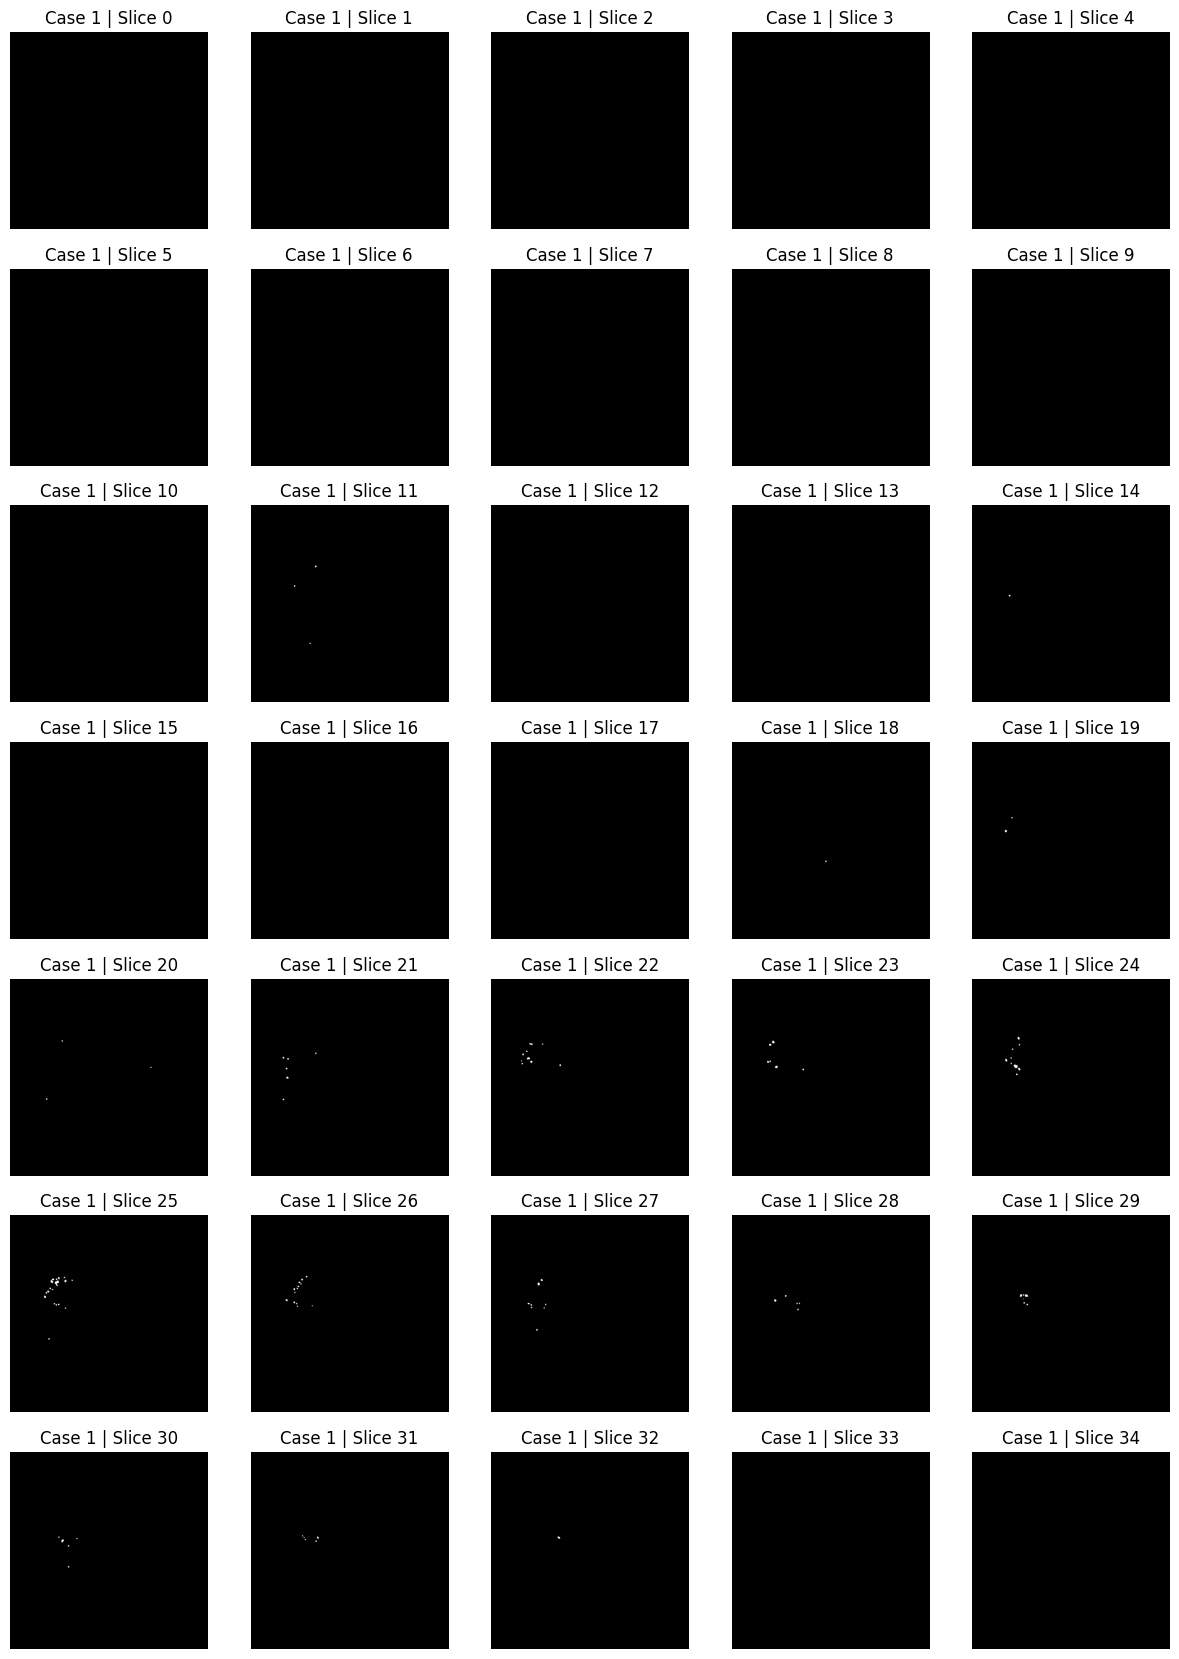

In [ ]:
plot_all_slices_from_array(predicted, case_index=1)

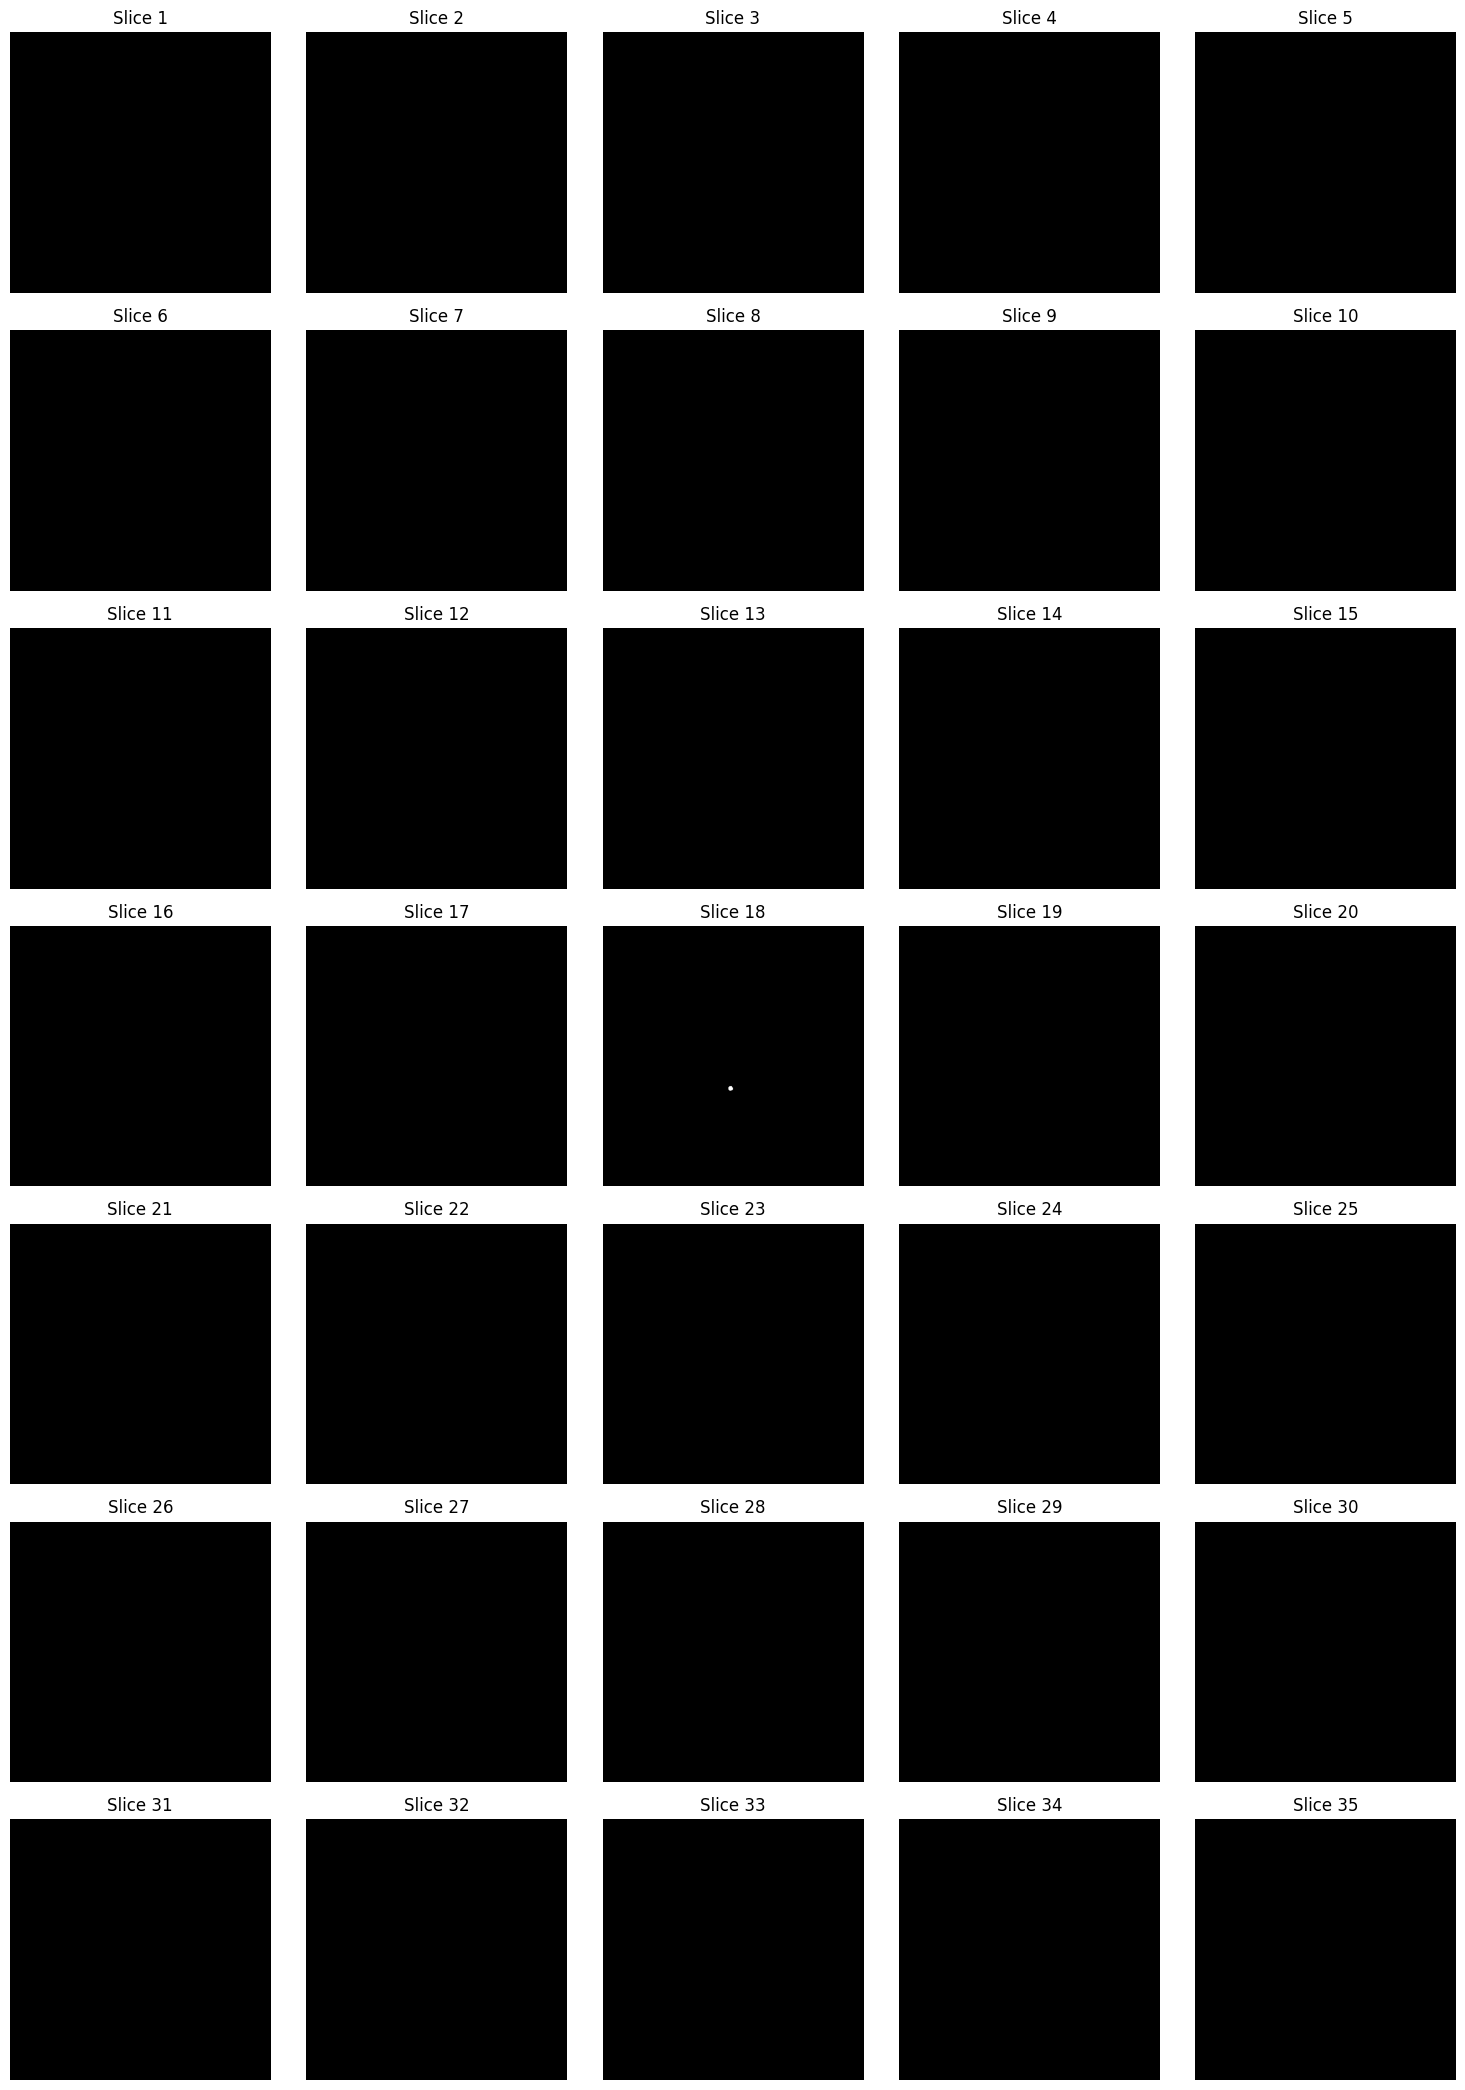

In [ ]:
plot_all_slices(masks[1])